# 顔画像データの線形AutoEncoderによる次元圧縮

## 線形AutoEncoderによる次元圧縮と主成分分析

出力層のニューロン数が入力の次元数と等しく，入力データそのものを出力の教師として学習するニューラルネットワークを AutoEncoder という．

## 準備

In [2]:
import numpy as np
import cv2
#import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import LFWDataset
import ipytools

## ネットワークの定義ほか

In [3]:
### definition of the network
#
class NN(nn.Module):

    def __init__(self, D=100, H=10):

        super(NN, self).__init__()
        # linear network => bias is not used
        self.fc1 = nn.Linear(D, H, bias=False)
        self.fc2 = nn.Linear(H, D, bias=False)

    def forward(self, X):
        Y = self.fc1(X)
        Z = self.fc2(Y)
        return Z

In [5]:
torch.manual_seed(0)

In [4]:
### device
#
use_gpu_if_available = True
if use_gpu_if_available and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('# using', device)

# using cpu


## 学習データの準備

In [6]:
### preparing the data (L)
#
dsL = LFWDataset.LFWDataset(LT='L')
NL = dsL.ndat
D = dsL.ndim
print(NL, D)
batchsize = 32
dlL = torch.utils.data.DataLoader(dsL, batch_size=batchsize, shuffle=True, drop_last=True)
nbatch = len(dlL)

# dataRoot = data/lfw-selected
4000 36864


## ネットワークの初期化など学習の準備

In [17]:
### initializing the network
#
H = 100  # 隠れ層ニューロン数
network = NN(D=D, H=H)
model = network.to(device)
print(model)
#optimizer = optim.Adam(model.parameters())  # lr=0.001
optimizer = optim.Adam(model.parameters(), lr=0.0005)
print(optimizer)

NN(
  (fc1): Linear(in_features=36864, out_features=100, bias=False)
  (fc2): Linear(in_features=100, out_features=36864, bias=False)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)


## 学習

以下のセルを複数回実行すると，前のパラメータを使って学習の続きをやることになるので注意．

In [10]:
%%time
# ↑ このセルの実行時間を測る．マシンの性能にもよるが，5分から10分くらい？

### learning
#
nepoch = 50

for i in range(nepoch):

    model.train()

    sqeL = np.empty(nbatch)

    for ib, Xb in enumerate(dlL):

        optimizer.zero_grad()
        Z = model(Xb)
        loss = F.mse_loss(Xb, Z, reduction='mean')
        loss.backward()
        optimizer.step()

        sqeL[ib] = loss.clone().cpu().detach().numpy()
            
    msqeL = np.mean(sqeL) # We can compute 'mean of the means' so that all the batch has the same size.
    print(i, msqeL)

0 0.011689507946372033
1 0.011261407025158406
2 0.009415795121341945
3 0.00881003986671567
4 0.008041874844580889
5 0.007485786836594343
6 0.007253831230103969
7 0.007005999322980642
8 0.006802563592791557
9 0.006677177559584379
10 0.006626881092786789
11 0.006370440408587455
12 0.0061044999733567236
13 0.006050854712724685
14 0.005952281959354878
15 0.0057753056809306145
16 0.005638397287577391
17 0.005701729964464903
18 0.0053428784273564815
19 0.005135104693472385
20 0.0050617303736507895
21 0.005051586829125881
22 0.004867295052856207
23 0.004929451916366815
24 0.004802424285560846
25 0.004767889216542244
26 0.004770598515868187
27 0.0045783039685338735
28 0.0046233608685433865
29 0.00462164268642664
30 0.0045247635785490275
31 0.004573670422658324
32 0.004564878974109888
33 0.004686435636132955
34 0.0047379803508520125
35 0.0047811804246157405
36 0.004654228433966637
37 0.004558722948655486
38 0.0046340991128236055
39 0.0045983573719859125
40 0.004780793704092502
41 0.004582662383

## 学習データでの評価

In [12]:
### evaluation (L)
#
model.eval()
dlL = torch.utils.data.DataLoader(dsL, batch_size=batchsize, shuffle=False, drop_last=False)

for ib, Xb in enumerate(dlL):
    Z = model(Xb)
    loss = F.mse_loss(Xb, Z, reduction='sum')
    sqeL[ib] = loss.clone().cpu().detach().numpy()

msqeL = np.sum(sqeL) / (NL*D)

print(f'# L: {msqeL}')

# L: 0.004539286365111669


## テストデータでの評価と画像の再構成

In [13]:
### evaluation & reconstruction (T)
#
model.eval()
dsT = LFWDataset.LFWDataset(LT='T')
NT = dsT.ndat
print(NT, D)
dlT = torch.utils.data.DataLoader(dsT, batch_size=batchsize, shuffle=False, drop_last=False)

sqeT = np.empty(len(dlT))
for ib, Xb in enumerate(dlT):
    Z = model(Xb)
    loss = F.mse_loss(Xb, Z, reduction='sum')
    sqeT[ib] = loss.clone().cpu().detach().numpy()
    if ib == 0:
        XT = Xb.cpu().detach().numpy()
        XT *= 255
        XT += dsT.meanL.reshape(-1)
        XT = np.clip(XT, 0, 255)
        ZT = Z.cpu().detach().numpy()
        ZT *= 255
        ZT += dsT.meanL.reshape(-1)
        ZT = np.clip(ZT, 0, 255)

msqeT = np.sum(sqeT) / (NT*D)
print(f'# T: {msqeT}')

# dataRoot = data/lfw-selected
1721 36864
# T: 0.004771324707606077


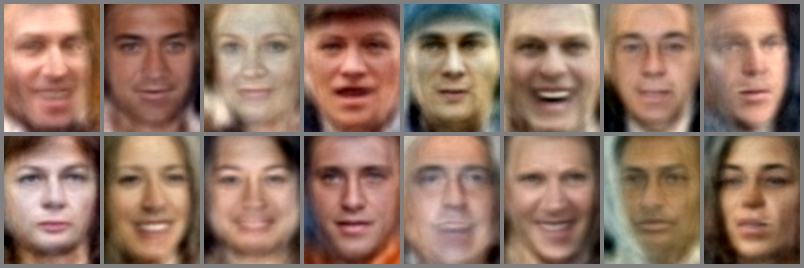

In [14]:
# 再構成画像
img = ipytools.mosaicImage(ZT[:16, ::], 8, 2)
#cv2.imwrite('hoge.png', img)
ipytools.displayImage(img)

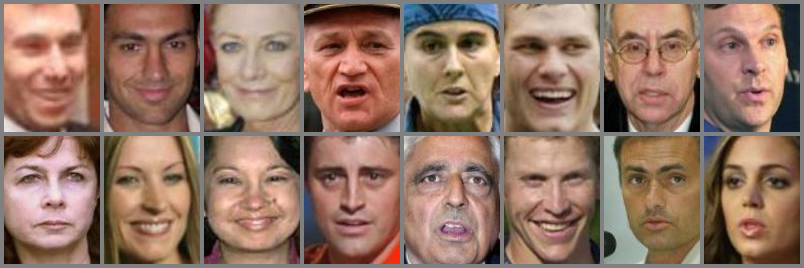

In [16]:
# 元画像
img = ipytools.mosaicImage(XT[:16, ::], 8, 2, nrow=128, ncol=96)
ipytools.displayImage(img)